In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from annoy import AnnoyIndex
from scipy.sparse import csr_matrix, vstack
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import time
import matplotlib.pyplot as plt

In [71]:
class ANN_Recommender:
    
    def __init__(self, ratings_file, movies_file, n_trees=10):
        self.sample_size = 1000
        init_time = time.time()
        self.movies_df = pd.read_csv(movies_file)
        print("Movies read in ", time.time() - init_time, "seconds --- task 1/5")
        
        init_time = time.time()
        self.ratings_df = pd.read_csv(ratings_file)
        print("Ratings read in ", time.time() - init_time, "seconds --- task 2/5")
        
        init_time = time.time()
        self.sample_movies_and_adjust_ratings()
        print("Matrix adjusted in ", time.time() - init_time, "seconds --- task 3/5")
        
        init_time = time.time()
        self.user_item_matrix, self.user_map, self.item_map = self.create_sparse_matrix(self.ratings_df)
        print("Sparse matrix created in ", time.time() - init_time, "seconds --- task 4/5")
        
        init_time = time.time()
        self.index = self.build_ann_index()  # Initialize Annoy index with the current data
        print("Index built in ", time.time() - init_time, "seconds --- task 5/5")
        print("Initialization completed")

    def sample_movies_and_adjust_ratings(self, random_seed=42):
        np.random.seed(random_seed)
        sampled_movies = np.random.choice(self.movies_df['movieId'].unique(), size=self.sample_size, replace=False)
        self.movies_df = self.movies_df[self.movies_df['movieId'].isin(sampled_movies)]
        self.ratings_df = self.ratings_df[self.ratings_df['movieId'].isin(sampled_movies)]

    def create_sparse_matrix(self, df):
        users = df['userId'].unique()
        items = df['movieId'].unique()
        user_map = {user: i for i, user in enumerate(users)}
        item_map = {item: i for i, item in enumerate(items)}
        mat = csr_matrix((df['rating'], ([user_map[x] for x in df['userId']], [item_map[x] for x in df['movieId']])),
                         shape=(len(users), len(items)))
        return mat, user_map, item_map

    def build_ann_index(self):
        n_components = self.user_item_matrix.shape[1]
        index = AnnoyIndex(n_components, 'angular')
        for i in range(self.user_item_matrix.shape[0]):
            v = self.user_item_matrix[i].toarray().ravel()
            index.add_item(i, v)
        index.build(10)
        return index

    def add_user_ratings(self, user_ratings):
        max_user_id = max(self.ratings_df['userId']) + 1
        for title, rating in user_ratings.items():
            if title not in self.movies_df['title'].values:
                new_id = self.movies_df['movieId'].max() + 1
                self.movies_df = pd.concat([self.movies_df, pd.DataFrame({'movieId': [new_id], 'title': [title]})], ignore_index=True)
                self.ratings_df = pd.concat([self.ratings_df, pd.DataFrame({'userId': [max_user_id], 'movieId': [new_id], 'rating': [rating]})], ignore_index=True)
            else:
                movie_id = self.movies_df[self.movies_df['title'] == title]['movieId'].iloc[0]
                self.ratings_df = pd.concat([self.ratings_df, pd.DataFrame({'userId': [max_user_id], 'movieId': [movie_id], 'rating': [rating]})], ignore_index=True)
        self.user_item_matrix, self.user_map, self.item_map = self.create_sparse_matrix(self.ratings_df)
        self.index = self.build_ann_index()  # Rebuild index with new data

    def recommend_items(self, user_ratings, n_recommendations=5):
        self.add_user_ratings(user_ratings)
        user_idx = self.user_map[max(self.user_map.keys())]
        try:
            indices, _ = self.index.get_nns_by_item(user_idx, n_recommendations, include_distances=True)
            valid_indices = [i for i in indices if i < len(self.item_map)]
            recommended_movie_ids = [list(self.item_map.keys())[i] for i in valid_indices]
            return self.movies_df[self.movies_df['movieId'].isin(recommended_movie_ids)]['title'].values
        except IndexError as e:
            print(e)
            return self.movies_df[self.movies_df['movieId'].isin(self.popular_movies)]['title'].values

    def visualize_recommendations(self, user_ratings, n_neighbors=20):
        recommended_titles = self.recommend_items(user_ratings, n_neighbors)
        fig, ax = plt.subplots(figsize=(10, 8))
        x = np.random.rand(len(recommended_titles))
        y = np.random.rand(len(recommended_titles))
        ax.scatter(x, y, color='red', label='Recommended Movies')
        for i, txt in enumerate(recommended_titles):
            ax.annotate(txt, (x[i], y[i]), fontsize=9)
        plt.title('Visualization of User-Specific Recommended Movies')
        plt.legend()
        plt.axis('off')
        plt.show()

In [72]:
recommender_ANN = ANN_Recommender('ml-latest/ratings.csv', 'ml-latest/movies.csv')

Movies read in  0.12075471878051758 seconds --- task 1/5
Ratings read in  10.255101680755615 seconds --- task 2/5
Matrix adjusted in  0.8532283306121826 seconds --- task 3/5
Sparse matrix created in  0.23634934425354004 seconds --- task 4/5
Index built in  19.247141361236572 seconds --- task 5/5
Initialization completed


In [73]:
def generate_recommendations_ANN(user_ratings):
    start_time = time.time()
    
    recommender_ANN.visualize_recommendations(new_user_ratings)
    
    time_total = time.time() - start_time

    print("Time taken in total:", time_total, "seconds")


In [74]:
new_user_ratings = {"My Son the Fanatic (1997)": 5, 
                    "Rover, The (2014)": 5, 
                    "Mighty Joe Young (1949)": 1}

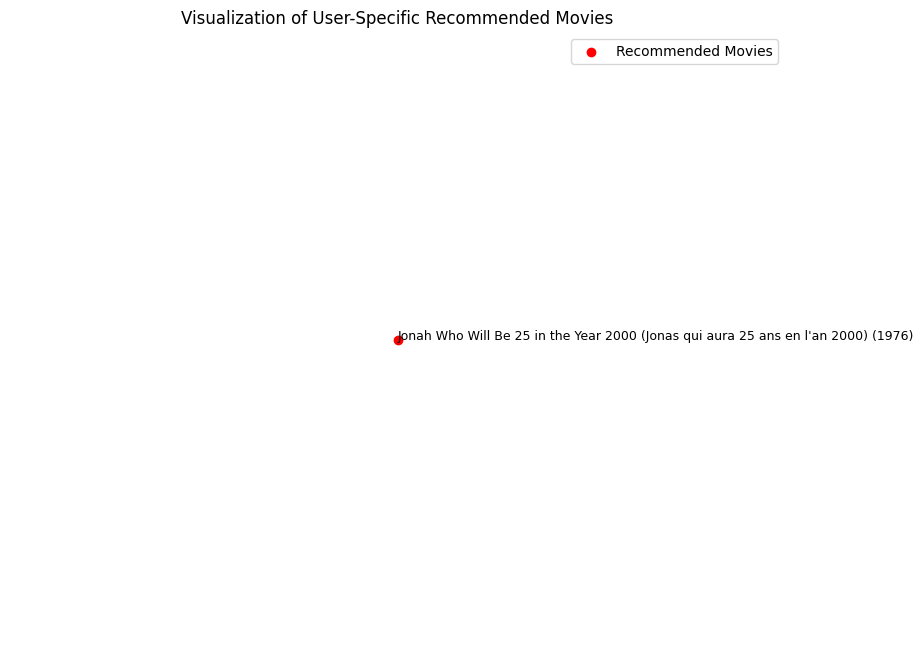

Time taken in total: 18.87410879135132 seconds


In [75]:
generate_recommendations_ANN(new_user_ratings)